In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import re
import os
from scipy import stats
from scripts.utils.my_fdr import fdr_threshold
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt


In [2]:
df_new_pheno = pd.read_csv('data/ukb_new_pheno_without_regression/whole/ukb_new_pheno.csv', index_col="eid")


df_disease = pd.read_csv('data/disease_with_pn.csv', index_col=0)
df_disease = df_disease.drop("other noninflammatory disorders of uterus", axis=1)
df_covariate = pd.read_csv("data//covariates.tsv", index_col=0, sep="\t")
df_covariate.index.name = "eid"

In [3]:
df_disease

,Stroke,Parkinson,Dementia,myocardial infarction,Asthma,COPD,multiple sclerosis,hypertension,nonrheumatic aortic valve disorders,cardiomyopathy,...,other diseases of liver,non-insulin-dependent diabetes mellitus,acute pancreatitis,other diseases of pancreas,acute renal failure,chronic renal failure,cystitis,hyperplasia of prostate,inflammatory diseases of prostate,inflammatory disease of uterus
eid,,,,,,,,,,,,,,,,,,,,,
1000022,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000063,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000081,0,0,0,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000170,0,0,0,0,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
1000287,0,0,0,-1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6023466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6023516,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6023611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_disease = df_disease.drop("inflammatory disease of uterus", axis=1)

In [5]:
diseases = list(df_disease.columns)
phenotypes = list(df_new_pheno.columns)
phenotype_name = dict(zip(phenotypes, df_new_pheno.columns.str.removeprefix("y_res_")))



phenotype_unit = list(df_new_pheno.columns)

In [6]:
# For each disease of interest, perform logistic regression
#
# disease ~ Sex + Age + Weight + Height + Imaging_Phenotype
#
n_disease = len(diseases)
n_pheno = len(phenotypes)
df_beta = pd.DataFrame(index=diseases, columns=phenotypes, dtype=float)
df_conf = df_beta.copy()
df_p_val = df_beta.copy()
df_n = {}

In [7]:
odd_df = pd.DataFrame()
for pheno in phenotypes:
    for disease in diseases:

        # Dependent variables
        y = df_disease[disease]
        y = y.loc[((y == 0) | (y == -1))]
        y = y.replace(-1, 1)
        # Independent variables
        # X = pd.concat([df_info[['Sex', 'Age']], df[[pheno]]], axis=1)
        X = pd.merge(df_covariate[['isMale', 'age', 'weight', 'height']], df_new_pheno[[pheno]], on="eid", how="inner")

        # Standard deviation of the phenotype for normalisation
        pheno_std = df_new_pheno[pheno].std()

        # Remove NaN values before regression
        valid_idx = pd.merge(X, y, on="eid", how="inner").dropna().index
        df_n[pheno] = len(valid_idx)
        
        # Logistic regression
        model = sm.Logit(y.loc[valid_idx], X.loc[valid_idx]).fit(disp=False)
        alpha = 0.05
        t = stats.t.isf(alpha / 2, model.df_resid)

        df_beta.loc[disease, pheno] = model.params[pheno] * pheno_std
        df_conf.loc[disease, pheno] = t * model.bse[pheno] * pheno_std
        df_p_val.loc[disease, pheno] = model.pvalues[pheno]

        odds = np.exp(df_beta.loc[disease, pheno])
        odds_lower = np.exp(df_beta.loc[disease, pheno] - df_conf.loc[disease, pheno])
        odds_upper = np.exp(df_beta.loc[disease, pheno] + df_conf.loc[disease, pheno])
        # print('{0}, per {1:.1f} {2}: Odds = {3:.2f} [{4:.2f}, {5:.2f}], p = {6:.3f}'.format(
        #     disease, pheno_std, pheno,
        #     odds, odds_lower, odds_upper, df_p_val.loc[disease, pheno]))
        temp = pd.DataFrame({"pheno": [pheno], "disease": [disease], "odds": [odds], "odds_lower": [odds_lower], "odds_upper": [odds_upper], "p": [df_p_val.loc[disease, pheno]]})
        odd_df = pd.concat([odd_df, temp])
odd_df.to_csv("data/disease_odd_before.csv", index=False)

In [8]:
disease

'inflammatory diseases of prostate'

In [9]:
# Bonferroni correction
p_bonf = 0.05 / (n_disease * n_pheno)

# FDR correction
p_fdr, _ = fdr_threshold(df_p_val.values.flatten(), 0.05)

# Number of phenotypes that is significantly associated with at least one of the IDPs
print('p_bonf = {0}'.format(p_bonf))
print('p_fdr = {0}'.format(p_fdr))

# Create the annotation text matrix
df_char = df_p_val.copy()
for disease in diseases:
    for pheno in phenotypes:
        if df_p_val.loc[disease, pheno] < p_bonf:
            df_char.loc[disease, pheno] = '**'
        elif df_p_val.loc[disease, pheno] < p_fdr:
            df_char.loc[disease, pheno] = '*'
        else:
            df_char.loc[disease, pheno] = ''


p_bonf = 7.936507936507937e-05
p_fdr = 0.013083608696962729


C:\Users\liumeng\AppData\Local\Temp\ipykernel_28960\708863274.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), fontsize=13)
C:\Users\liumeng\AppData\Local\Temp\ipykernel_28960\708863274.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), fontsize=13)


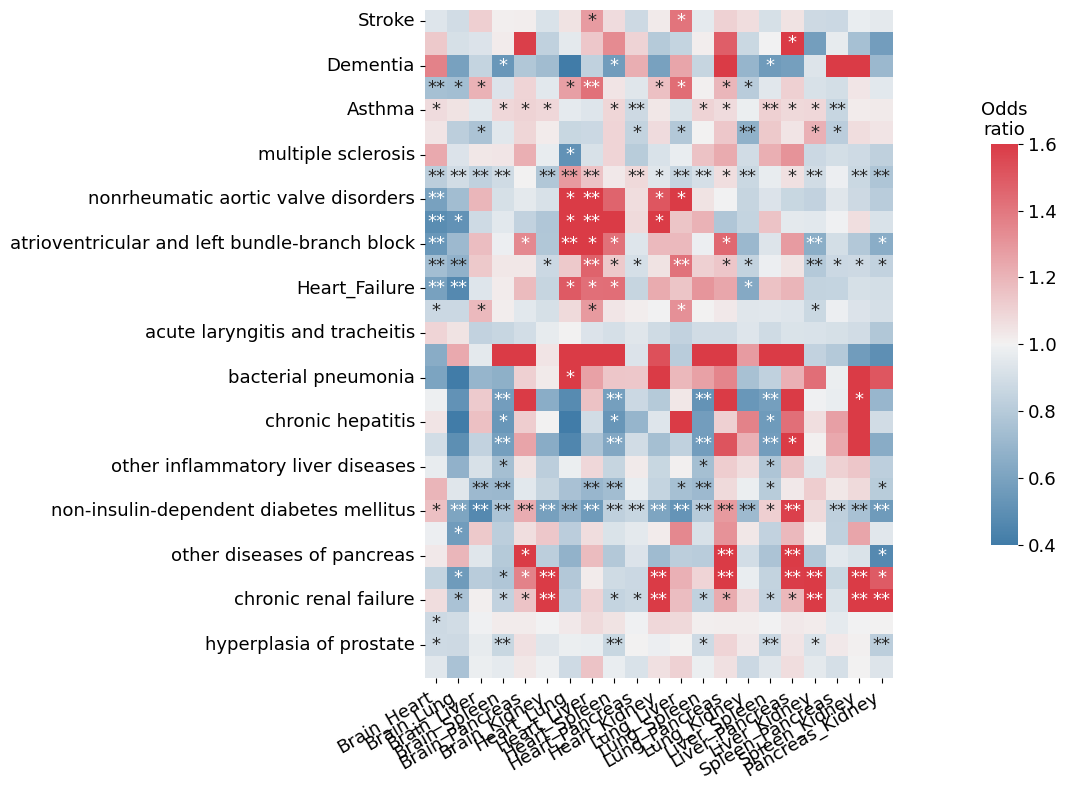

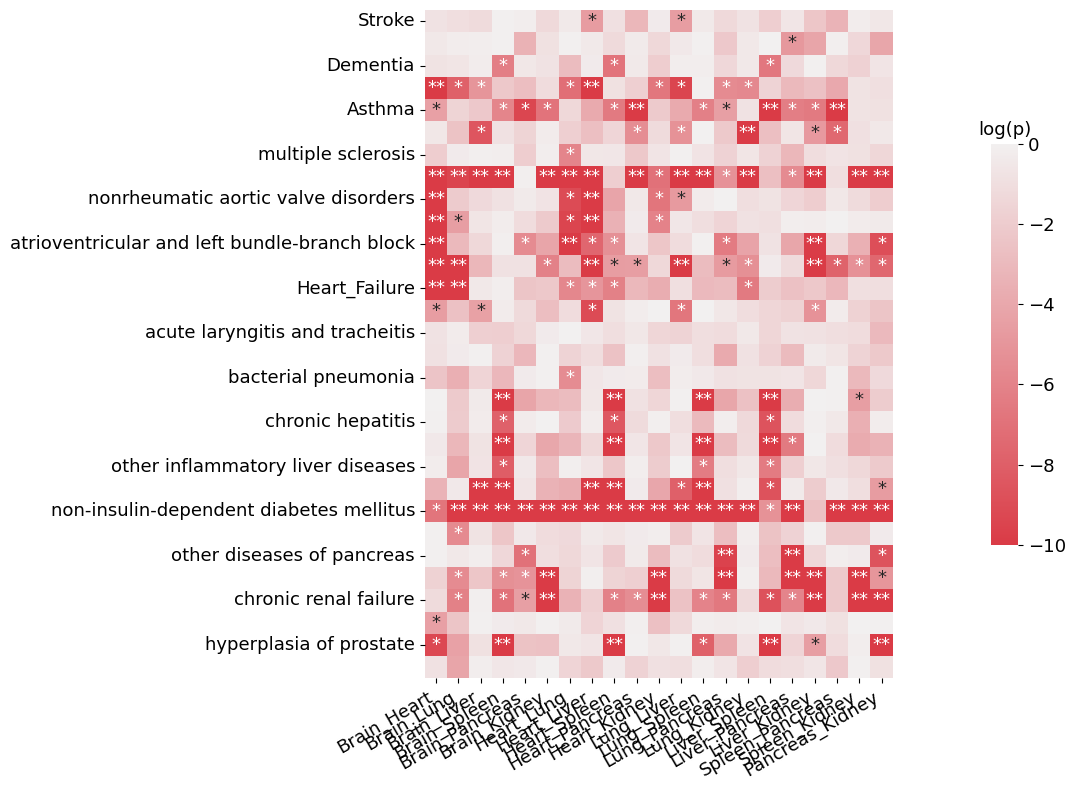

In [10]:
# Plot the heatmap for the odds ratios
plt.figure()
df_beta2 = df_beta.rename(columns=phenotype_name)
ax = sns.heatmap(np.exp(df_beta2), annot=df_char, annot_kws={'size': 13}, fmt='',
                 vmin=0.4, vmax=1.6, center=1, square=True,
                 cmap=sns.diverging_palette(240, 10, as_cmap=True),
                 cbar_kws={'shrink': .6, 'aspect': 15})
cbar_ax = ax.figure.get_axes()[-1]
cbar_ax.set_title('Odds\nratio', fontsize=13)
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), fontsize=13)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=13, rotation=30, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=13)
plt.gcf().set_size_inches(20, 8)
plt.tight_layout()
plt.savefig('plot/plot_clinical_outcome_odds.png', bbox_inches='tight')

# Plot the heatmap for the logarithm of p-values
plt.figure()
df_p_val2 = df_p_val.rename(columns=phenotype_name)
ax = sns.heatmap(np.log(df_p_val2), annot=df_char, annot_kws={'size': 13}, fmt='',
                 vmin=-10, vmax=0, square=True,
                 cmap=sns.light_palette('#da3b46', reverse=True, as_cmap=True),
                 cbar_kws={"shrink": .6, 'aspect': 15})
cbar_ax = ax.figure.get_axes()[-1]
cbar_ax.set_title('log(p)', fontsize=13)
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), fontsize=13)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=13, rotation=30, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=13)
plt.gcf().set_size_inches(20, 8)
plt.tight_layout()
plt.savefig('plot/plot_clinical_outcome_p_val.png', bbox_inches='tight')
# plt.show()
